In [1]:
from mlgrad.risk import ERisk, ERiskGB
from mlgrad.loss import SquareErrorLoss
from mlgrad.model import LinearFuncModel, SigmaNeuronModel, FFNetworkModel, \
                        FFNetworkFuncModel, SigmaNeuronModelLayer, LinearModel
from mlgrad.func import SoftPlus, Sqrt, Sigmoidal, HingeSqrt, Arctang

from mlgrad import erm_fg, erm_irgd, fg, erm_fg, erisk
from mlgrad.regr import m_regression_irls
from mlgrad.af import averaging_function
from mlgrad.weights import MWeights

import numpy as np

In [2]:
import sklearn.datasets as datasets
import sklearn.metrics as metrics
import sklearn.preprocessing as preprocessing
import matplotlib.pyplot as plt

In [3]:
X, Y = datasets.load_diabetes(return_X_y=True)
N = len(X)
print(X.shape, X.dtype)
print(Y.shape, Y.dtype)

(442, 10) float64
(442,) float64


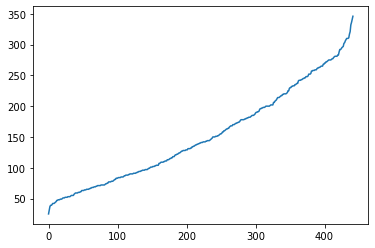

In [4]:
plt.plot(sorted(Y))
plt.show()

In [5]:
X_o = preprocessing.scale(X)
Y_o = preprocessing.scale(Y) #Y.copy()
print(X_o)

[[ 0.80050009  1.06548848  1.29708846 ... -0.05449919  0.41855058
  -0.37098854]
 [-0.03956713 -0.93853666 -1.08218016 ... -0.83030083 -1.43655059
  -1.93847913]
 [ 1.79330681  1.06548848  0.93453324 ... -0.05449919  0.06020733
  -0.54515416]
 ...
 [ 0.87686984  1.06548848 -0.33441002 ... -0.23293356 -0.98558469
   0.32567395]
 [-0.9560041  -0.93853666  0.82123474 ...  0.55838411  0.93615545
  -0.54515416]
 [-0.9560041  -0.93853666 -1.53537419 ... -0.83030083 -0.08871747
   0.06442552]]


In [6]:
from mlgrad.boost.gb_regression import gb_fit, gb_fit_agg

def new_model(n):
    mod = SigmaNeuronModel(Sigmoidal(0.5), n)
    mod.init_param()
    return mod

m = 100

In [7]:
gb = gb_fit(X_o, Y_o, new_model, h=0.01, n_iter=m)
# gb = gb_fit_agg(X_o, Y_o, new_model, aggname='AM', h=0.01, n_iter=m)
lfm, lvals = gb.complex_model, gb.lvals

In [8]:
alpha=0.98
gb_agg = gb_fit_agg(X_o, Y_o, new_model, aggname='WM', alpha=alpha, h=0.02, n_iter=m)
lfm_agg, lvals_agg = gb_agg.complex_model, gb_agg.lvals

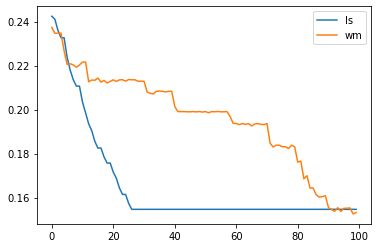

In [9]:
plt.plot(lvals, label='ls')
plt.plot(lvals_agg, label='wm')
plt.legend()
plt.show()

In [10]:
print(np.array(lfm.weights))
print(np.array(lfm_agg.weights))

[ 1.43900087e+00  1.07544468e+00  1.00960999e-01  1.06113488e+00
  5.07350691e-02 -1.34164283e-01  1.03852470e+00 -9.37568993e-02
  1.00025947e+00  2.49158826e-02  1.22035647e-01  1.07787638e+00
  1.00086794e-01  9.65545174e-01  9.83725647e-02  1.00376466e+00
 -4.49124269e-02  9.03575521e-02  1.01968882e+00 -3.30928949e-02
 -9.16485965e-02  9.90333598e-01 -9.43538582e-02  1.05348762e+00
  8.49700745e-02 -9.07367201e-02  1.05452135e+00  2.40121116e-02
 -1.71137156e-03  4.10247655e-03 -2.77971924e-03 -1.56371812e-03
  4.28105724e-03  1.35020668e-03 -2.43683131e-03 -8.08554948e-03
  4.86295116e-03 -2.78463189e-03 -2.91815575e-03  2.54036716e-03
  2.41265208e-03 -1.98244401e-03  6.63281093e-03  1.67008771e-03
 -2.38486380e-03 -1.80119270e-03  8.88911741e-04  2.26281920e-03
 -9.99370192e-04  1.57982507e-03  1.40442328e-03 -1.42727834e-03
  1.38632522e-03  4.33018175e-03 -1.73999950e-03  8.73817892e-04
 -1.77291131e-03  2.05316957e-03  5.83174916e-03 -1.20998251e-03
 -2.79874907e-03  1.15365

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


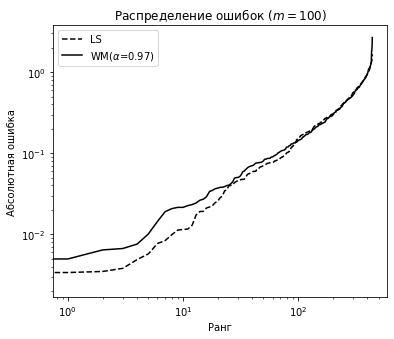

In [11]:
plt.figure(figsize=(6,5))
plt.xlabel('Ранг')
plt.ylabel('Абсолютная ошибка')
plt.title("Распределение ошибок ($m=$%s)" % m)
plt.loglog(sorted([abs(lfm(X_o[k])-Y_o[k]) for k in range(N)]), linestyle='--', color='k', label='LS')
plt.loglog(sorted([abs(lfm_agg(X_o[k])-Y_o[k]) for k in range(N)]), linestyle='-', color='k', label=r"WM($\alpha$=0.97)")
plt.legend()
plt.savefig('diabets_%.0f_%s_errors.eps' % (alpha*100,m))
plt.show()

In [12]:
Y_ls = lfm.evaluate_all(X_o)
Y_agg = lfm_agg.evaluate_all(X_o)

In [13]:
acc_ls = metrics.mean_absolute_error(Y_o, Y_ls)
acc_wm = metrics.mean_absolute_error(Y_o, Y_agg)
print(acc_ls, acc_wm)

0.43614039805159666 0.44368041561440985


In [14]:
acc_ls = metrics.median_absolute_error(Y_o, Y_ls)
acc_wm = metrics.median_absolute_error(Y_o, Y_agg)
print(acc_ls, acc_wm)

0.345500081584313 0.3394118704779896


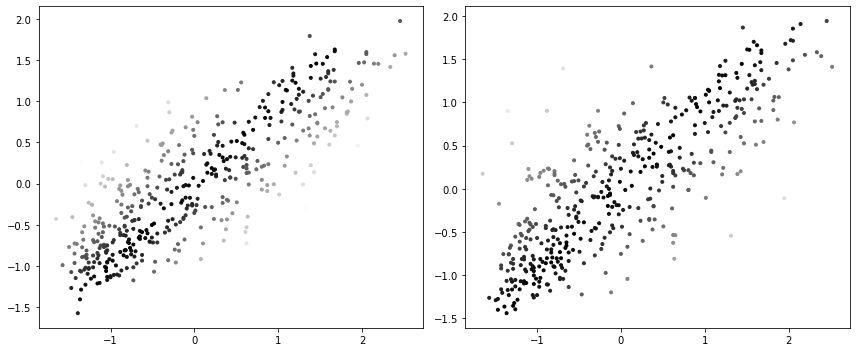

In [15]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(Y_o, Y_ls, c=np.abs(Y_o-Y_ls), s=9, cmap=plt.cm.Greys_r)
# plt.plot([0,50], [0,50], color='k')
plt.subplot(1,2,2)
plt.scatter(Y_o, Y_agg, c=np.abs(Y_o-Y_agg), s=9, cmap=plt.cm.Greys_r)
# plt.plot([0,50], [0,50], color='k')
plt.subplot(1,2,2)
plt.tight_layout()
plt.show()